In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class CircleDataset(Dataset):
    def __init__(self, size, num_samples):
        self.size = size
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = np.zeros((self.size, self.size), dtype=np.float32)
        mask = np.zeros((self.size, self.size), dtype=np.float32)

        # Generate random circle
        radius = np.random.randint(self.size // 8, self.size // 4)
        x, y = np.random.randint(radius, self.size - radius, size=2)

        for i in range(self.size):
            for j in range(self.size):
                if (i - x) ** 2 + (j - y) ** 2 <= radius ** 2:
                    img[i, j] = 1.0
                    mask[i, j] = 1.0

        return ToTensor()(img), ToTensor()(mask)

# Example usage
dataset = CircleDataset(size=64, num_samples=1000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class SimpleTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, num_layers):
        super(SimpleTransformer, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        self.patch_embedding = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        self.transformer = nn.Transformer(embed_dim, num_heads, num_layers, num_layers)
        self.head = nn.Linear(embed_dim, patch_size * patch_size)

    def forward(self, x):
        # Patchify
        x = self.patch_embedding(x)  # (B, embed_dim, H', W')
        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, num_patches, embed_dim)
        x = x + self.position_embedding

        # Transformer
        x = self.transformer(x, x)  # (B, num_patches, embed_dim)

        # Output head
        x = self.head(x)  # (B, num_patches, patch_size * patch_size)
        x = rearrange(x, 'b (h w) (p1 p2) -> b 1 (h p1) (w p2)', h=int(self.img_size/self.patch_size), w=int(self.img_size/self.patch_size), p1=self.patch_size, p2=self.patch_size)
        return x

/usr4/ec523/ipboyd/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.3158


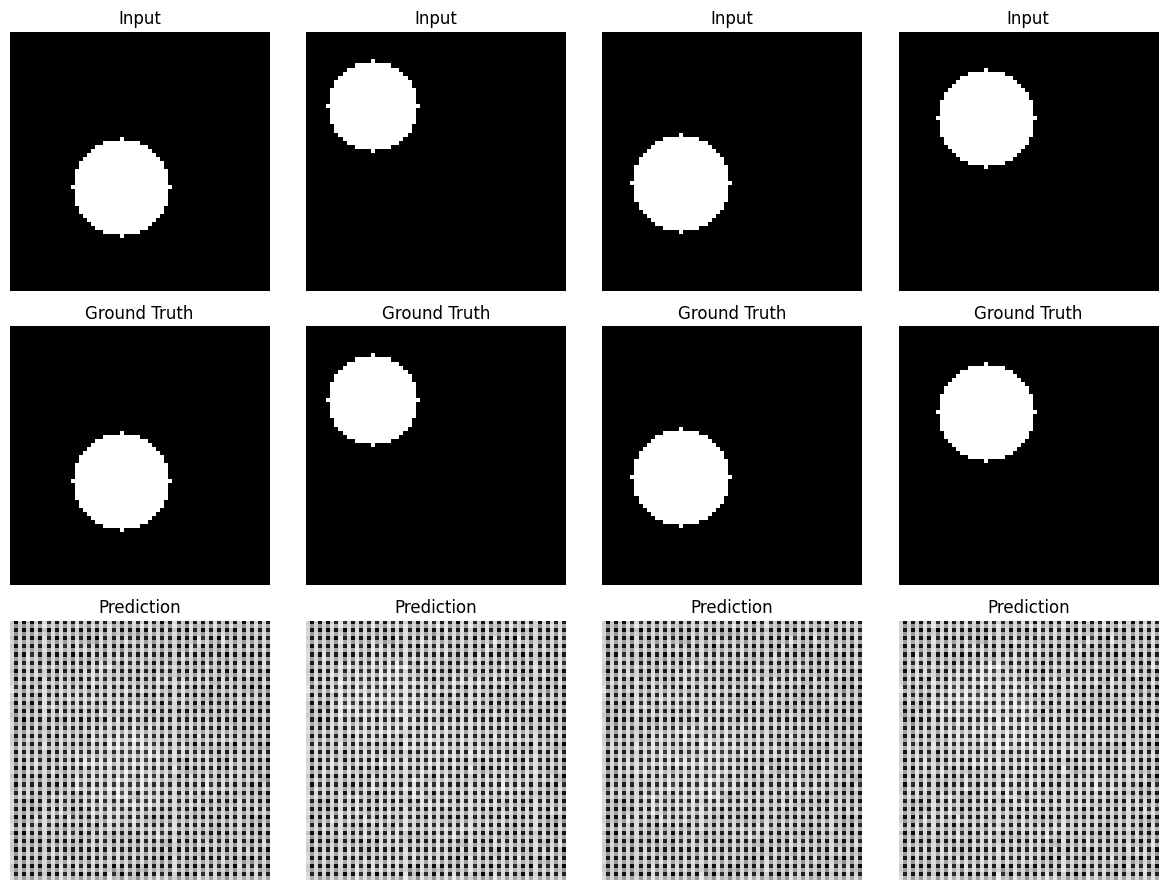

Epoch 2, Loss: 0.0907


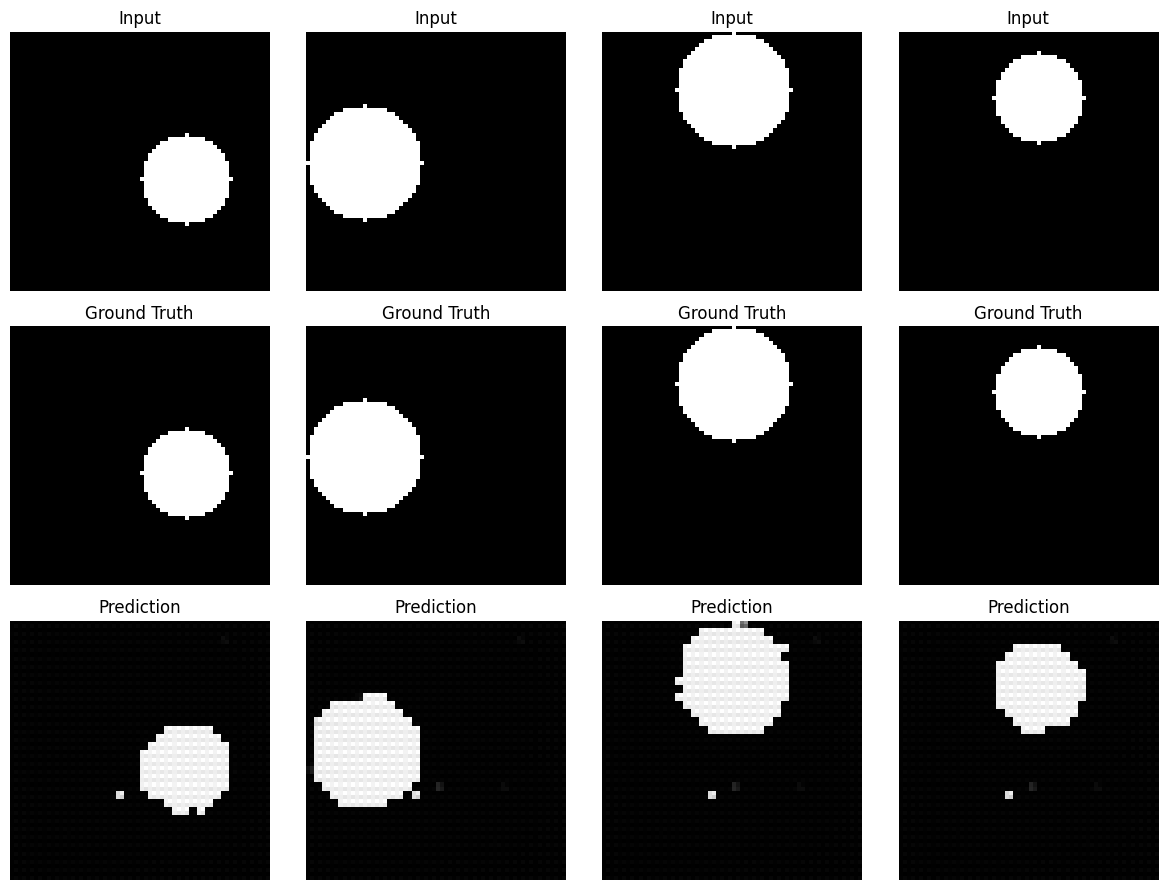

Epoch 3, Loss: 0.0310


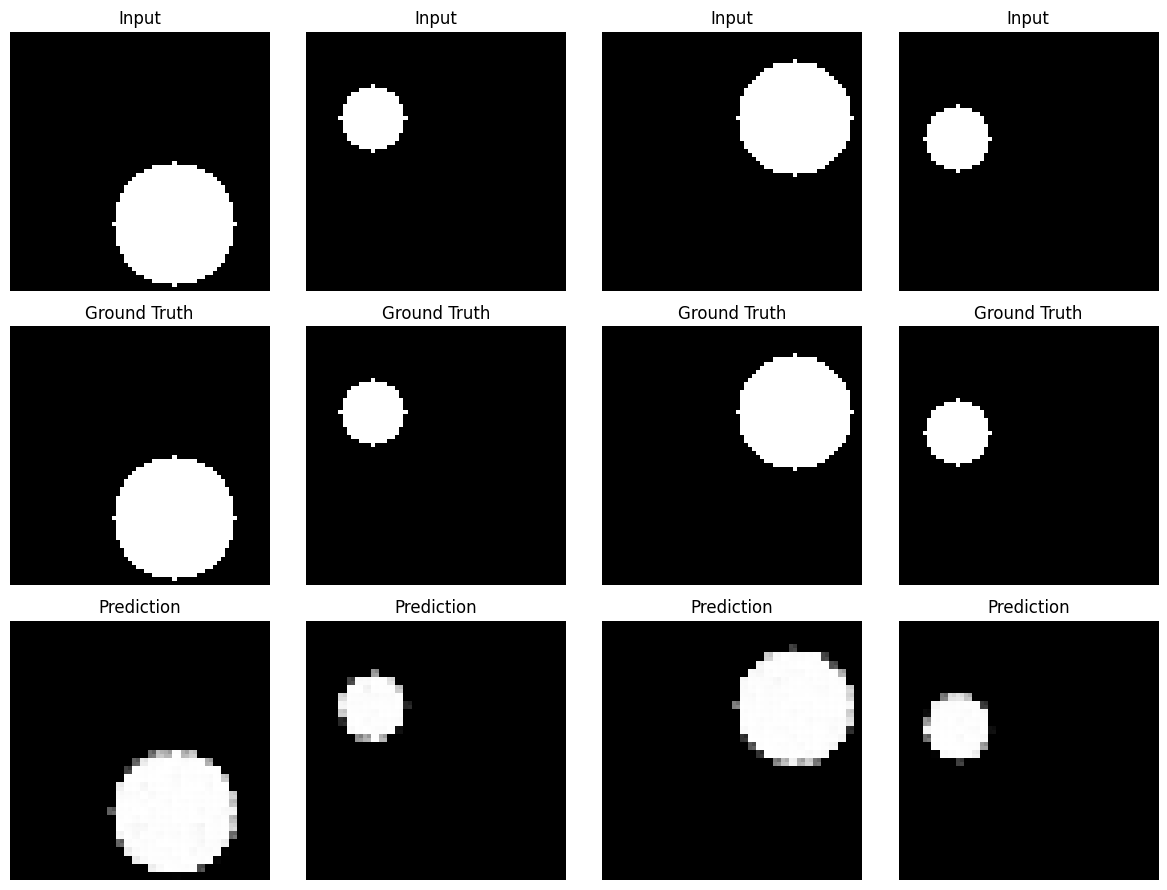

Epoch 4, Loss: 0.0207


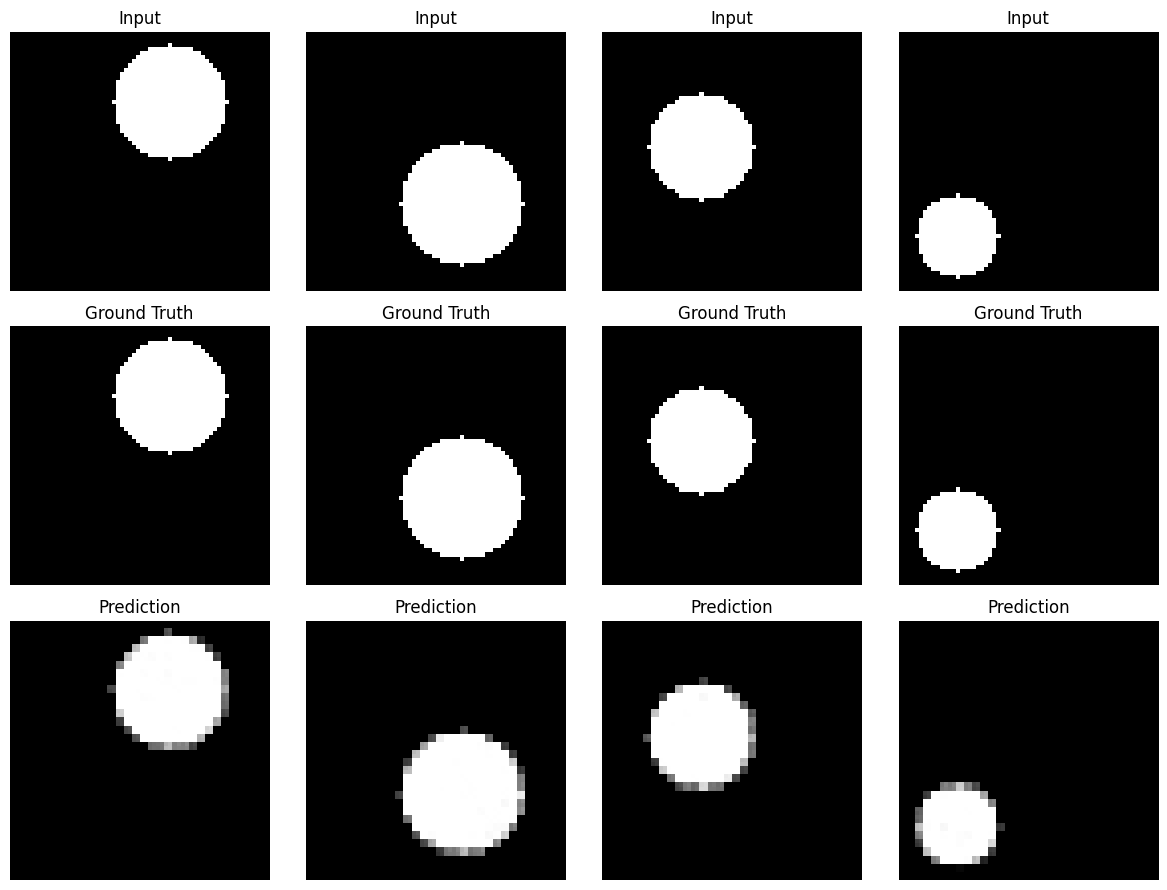

Epoch 5, Loss: 0.0178


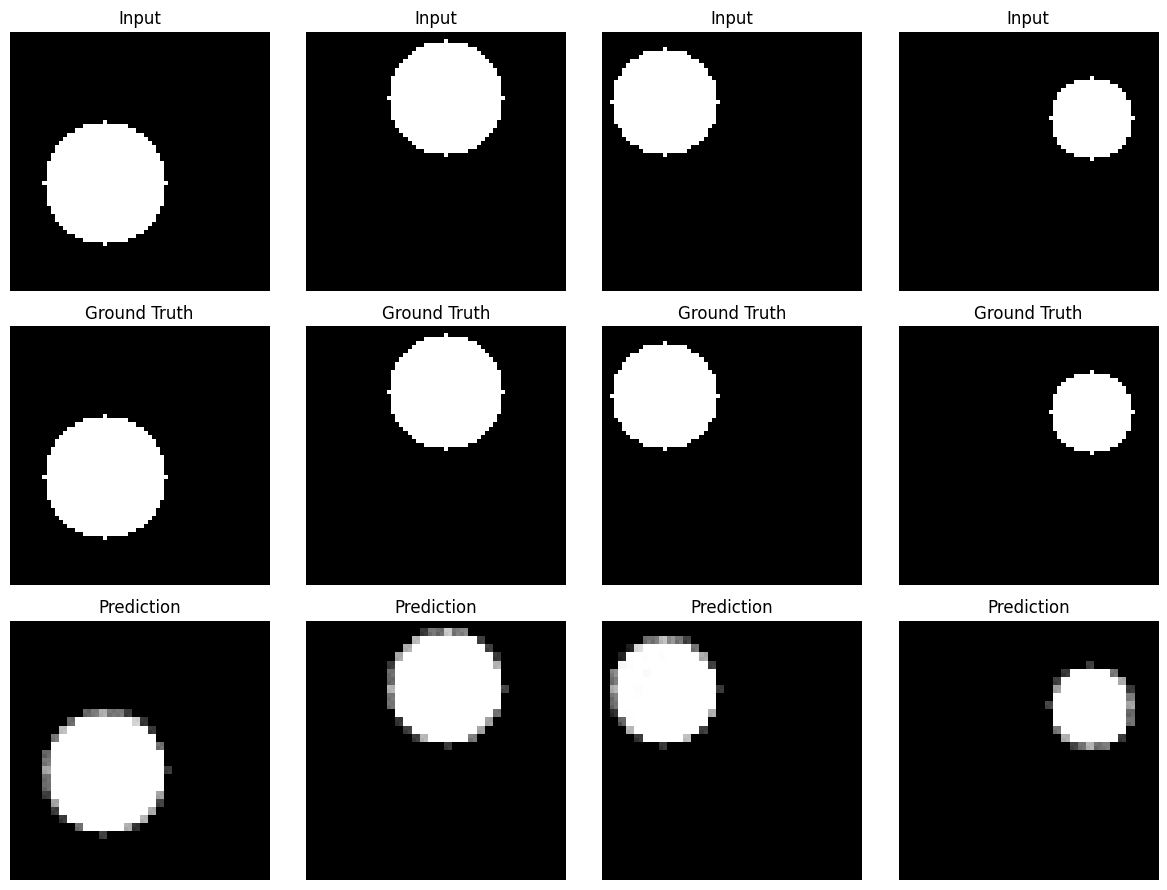

Epoch 6, Loss: 0.0161


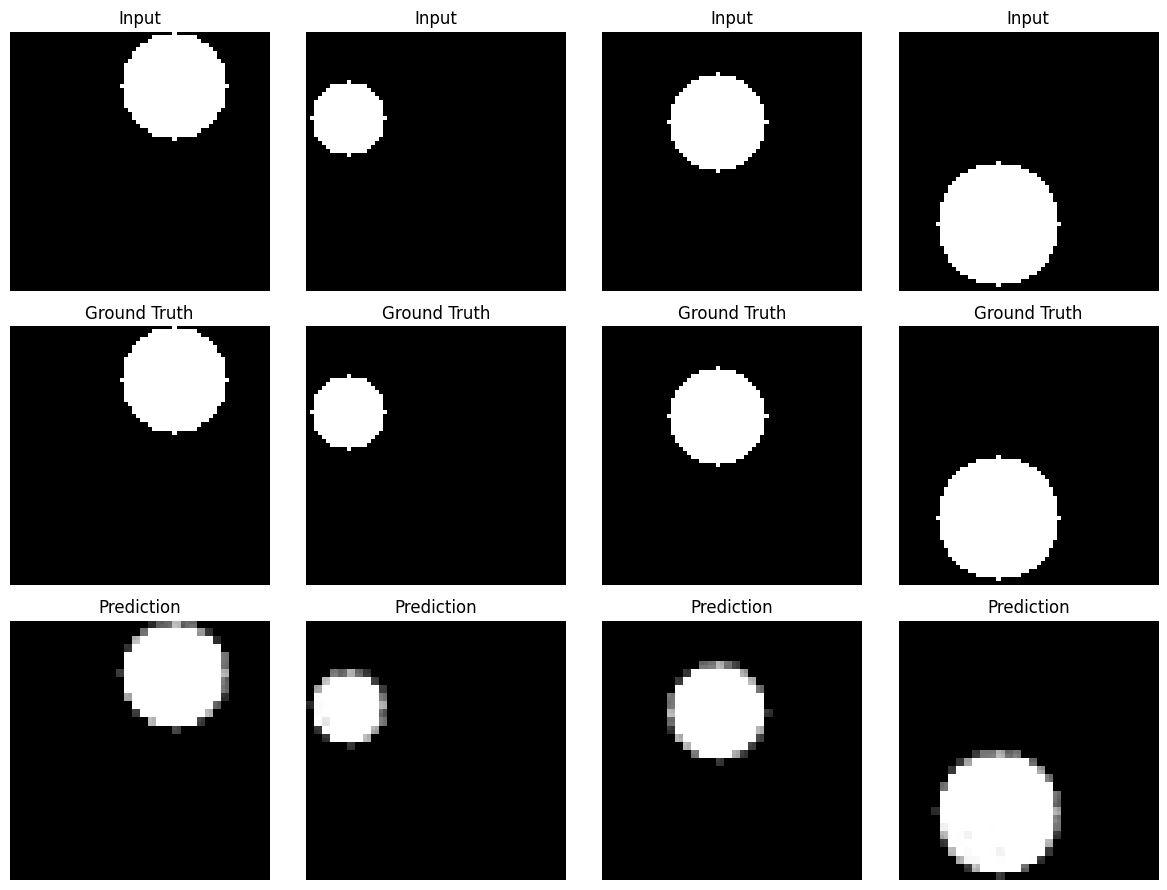

Epoch 7, Loss: 0.0084


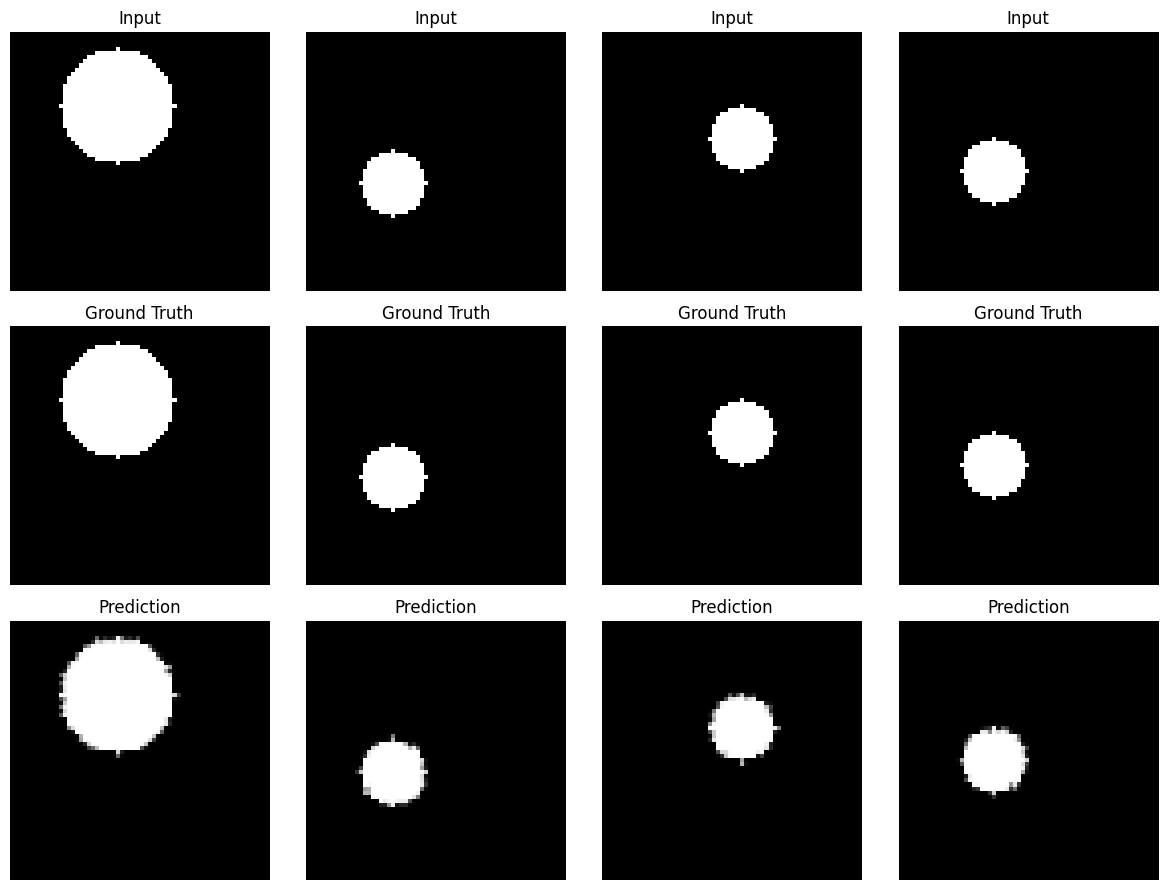

Epoch 8, Loss: 0.0048


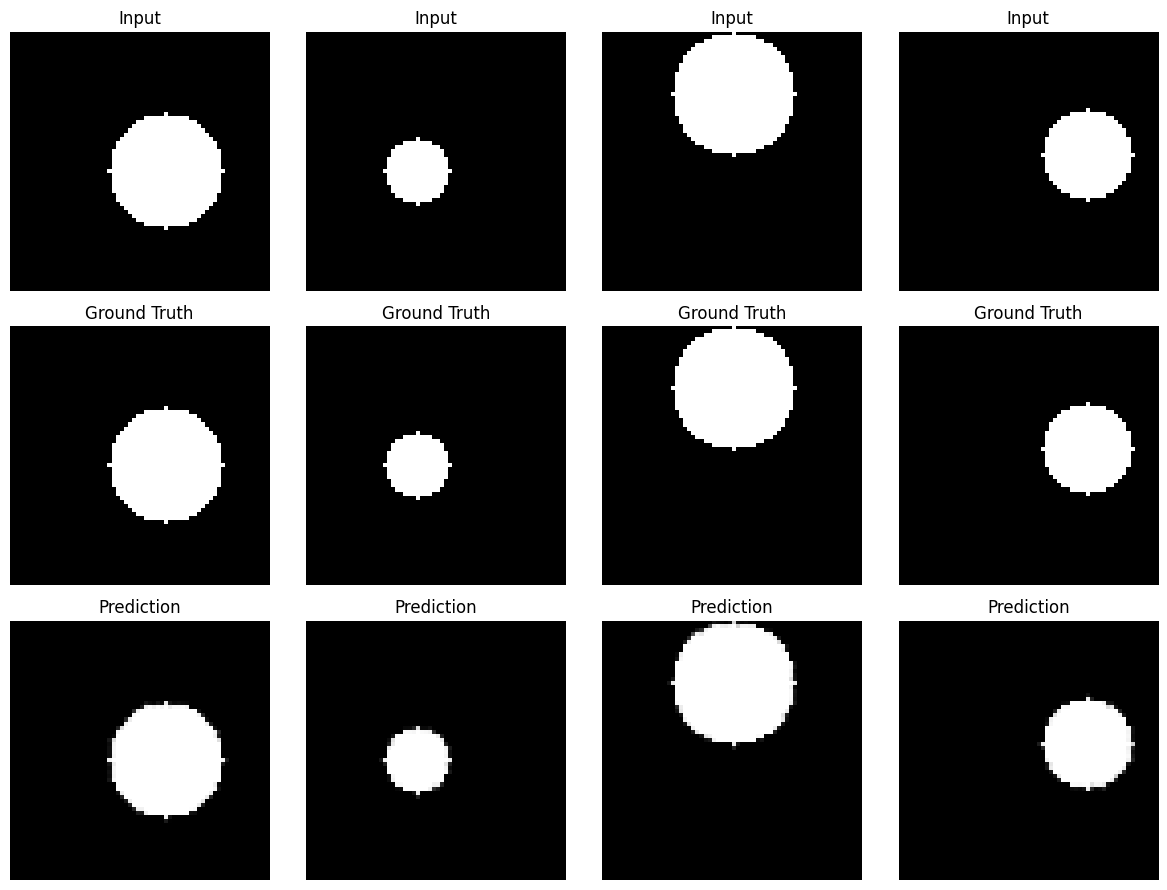

Epoch 9, Loss: 0.0026


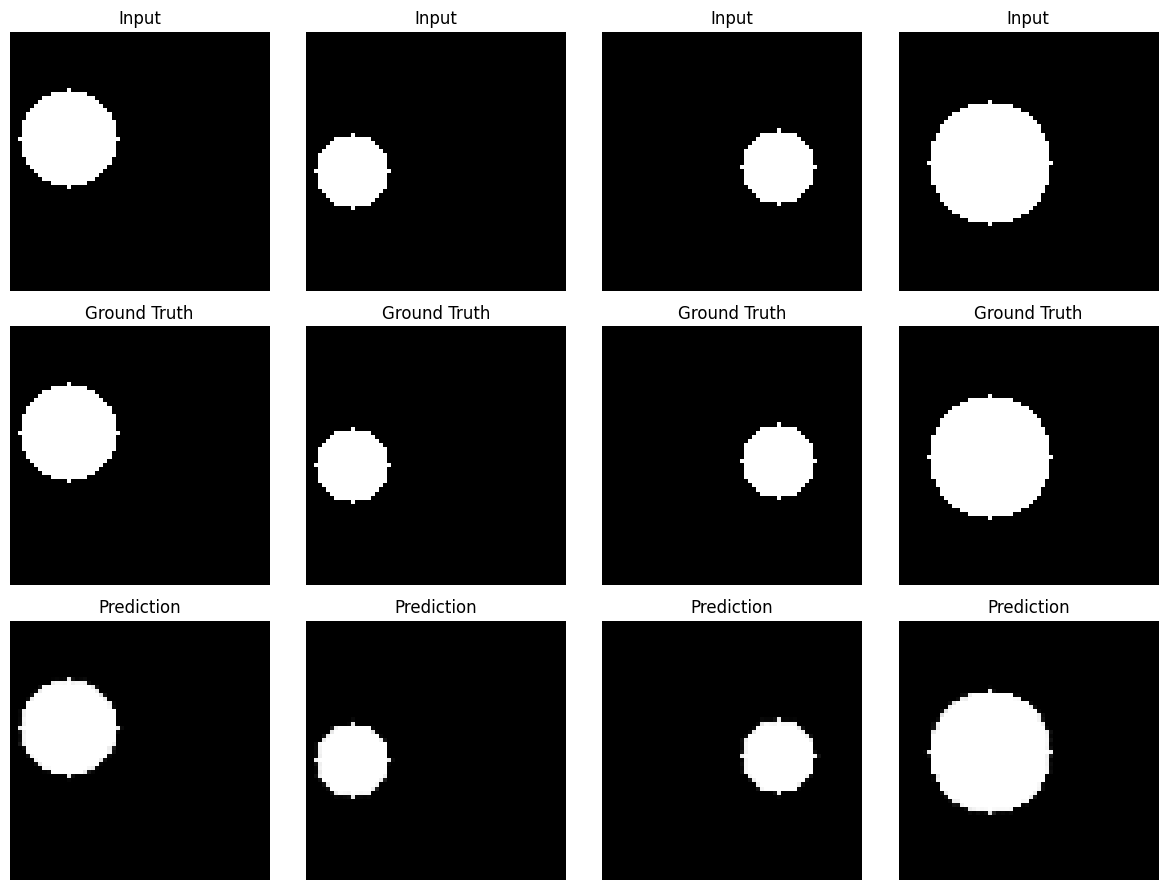

Epoch 10, Loss: 0.0018


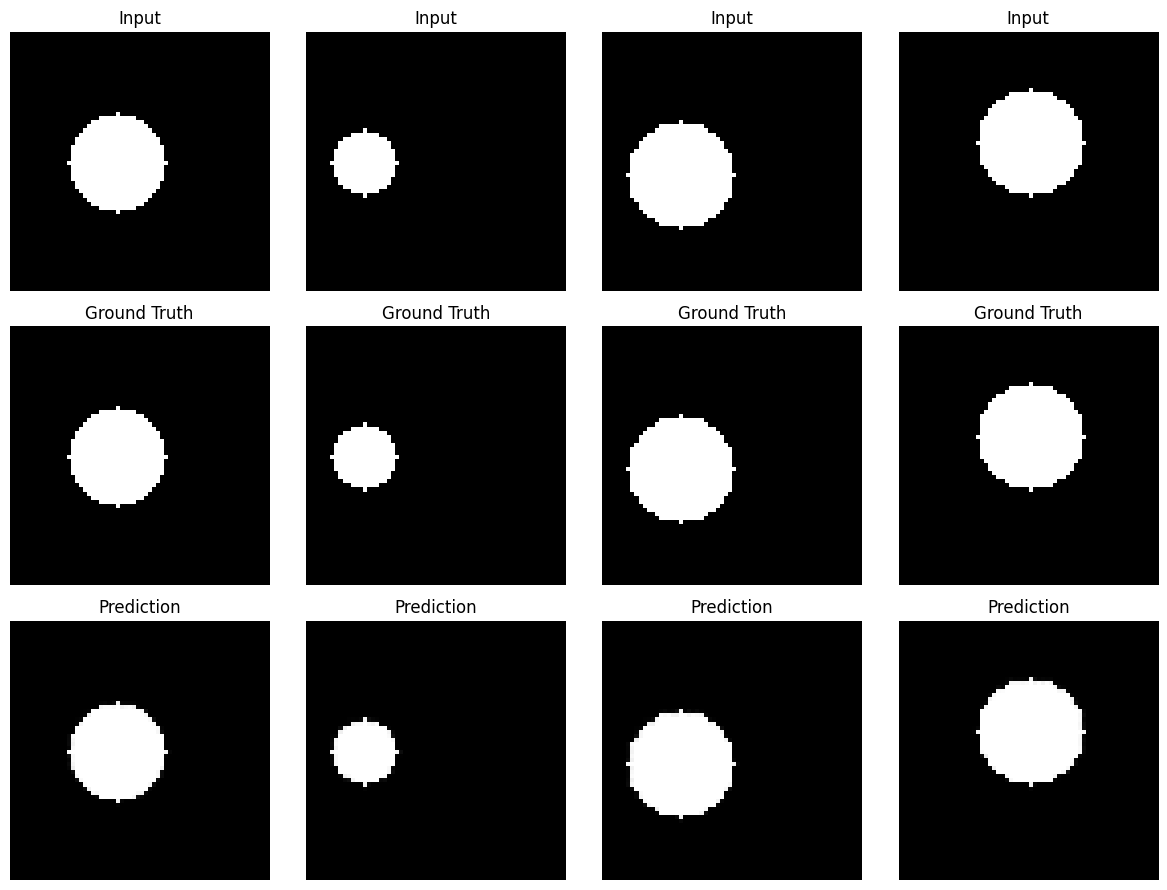

In [7]:
import torch.optim as optim

# Model and GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleTransformer(img_size=64, patch_size=2, embed_dim=128, num_heads=4, num_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

import matplotlib.pyplot as plt

for epoch in range(10):
    model.train()  # Ensure model is in training mode
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Log training loss
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

    # Visualize predictions on the first batch
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))  # Apply sigmoid to get probabilities
            break  # Only visualize the first batch

    # Convert tensors to numpy arrays for visualization
    images_np = images.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = outputs.cpu().numpy()

    # Plot input, ground truth, and predictions
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):  # Show up to 4 examples from the batch
        axes[0, i].imshow(images_np[i, 0], cmap="gray")
        axes[0, i].set_title("Input")
        axes[0, i].axis("off")

        axes[1, i].imshow(masks_np[i, 0], cmap="gray")
        axes[1, i].set_title("Ground Truth")
        axes[1, i].axis("off")

        axes[2, i].imshow(outputs_np[i, 0], cmap="gray")
        axes[2, i].set_title("Prediction")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

In [3]:
pip install einops

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
